In [1]:
import numpy as np
import pandas as pd
import math
import datetime
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [2]:
class DataProcess:
    def __init__(self, path, country):
        self.path = path
        self.country = country
        self.data = pd.read_csv(self.path)
        self.data = self.data.loc[self.data.loc[:,'Country/Region']==self.country]
        self.data.index=[i for i in range (self.data.shape[0])]
        #self.data=self.data.loc[data.loc[:,'Country/Region']==country]
    def ExtractConfirmedCases(self):
        self.data=pd.DataFrame(self.data.Confirmed)
        return(pd.DataFrame(self.data.Confirmed))
    def ExtractRecoveredCases(self):
        self.data=pd.DataFrame(self.data.Recovered)
        return(pd.DataFrame(self.data.Recovered))
    def ExtractDeathsCases(self):
        self.data=pd.DataFrame(self.data.Deaths)
        return(pd.DataFrame(self.data.Deaths))

Define our LSTM model

In [3]:
model = Sequential()
model.add(LSTM(units=256,input_shape=(None,1),return_sequences=True))
model.add(LSTM(units=256))
model.add(Dense(units=1))
model.compile(loss='mse',optimizer='adam')

In [4]:
path= "C:/cov/ysx/time-series-19-covid-combined.csv"
country='US'

First, we predict Confirmed cases in USA.

In [5]:
df_Confirmed = DataProcess(path,country).ExtractConfirmedCases()
#scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_Confirmed = scaler.fit_transform(df_Confirmed)
look_back = 1 
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
trainX, trainY = create_dataset(data_Confirmed, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))

In [6]:
#train our model
model.fit(trainX, trainY, epochs=10, batch_size=1)

Epoch 1/10
72/72 [==============================] - 4s 53ms/step - loss: 0.0311
Epoch 2/10
72/72 [==============================] - 2s 28ms/step - loss: 0.0077
Epoch 3/10
72/72 [==============================] - 2s 27ms/step - loss: 1.2957e-04
Epoch 4/10
72/72 [==============================] - 2s 25ms/step - loss: 1.4582e-04
Epoch 5/10
72/72 [==============================] - 2s 28ms/step - loss: 1.2220e-04
Epoch 6/10
72/72 [==============================] - 2s 28ms/step - loss: 2.0833e-04
Epoch 7/10
72/72 [==============================] - 2s 29ms/step - loss: 1.6756e-04
Epoch 8/10
72/72 [==============================] - 2s 26ms/step - loss: 1.0503e-04
Epoch 9/10
72/72 [==============================] - 2s 27ms/step - loss: 1.6236e-04
Epoch 10/10
72/72 [==============================] - 2s 28ms/step - loss: 1.7526e-04


In [7]:
#make prediction 
PredictConfirmed = []
TimePredict = 100
for i in range(TimePredict):
    predict_step=model.predict(trainX)[-1]
    PredictConfirmed.append(predict_step)
    trainX = np.append(trainX[1:,:,:],[[predict_step]],axis=0)
predict_not_scale=scaler.inverse_transform(PredictConfirmed)
final_df_Confirmed=pd.DataFrame(np.append(df_Confirmed,predict_not_scale[2::,]))

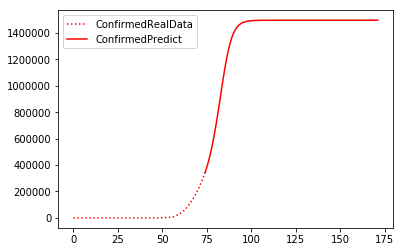

In [8]:
#Visualization of our result 
plt.plot(final_df_Confirmed.iloc[:len(data_Confirmed)+1,],color="red",linestyle=":",label='ConfirmedRealData')
plt.plot(final_df_Confirmed.iloc[len(data_Confirmed)::,],color="red",label='ConfirmedPredict')
plt.legend()


In [9]:
#Second, we predict Deaths cases in USA.
df_Deaths=DataProcess(path,country).ExtractDeathsCases()
scaler = MinMaxScaler(feature_range=(0, 1))
data_Deaths = scaler.fit_transform(df_Deaths)
look_back = 1 
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
trainX, trainY = create_dataset(data_Deaths, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))

In [10]:
#train our model
model.fit(trainX, trainY, epochs=10, batch_size=1)

Epoch 1/10
72/72 [==============================] - 2s 29ms/step - loss: 7.2650e-05
Epoch 2/10
72/72 [==============================] - 2s 25ms/step - loss: 2.9498e-04
Epoch 3/10
72/72 [==============================] - 2s 26ms/step - loss: 1.5876e-04
Epoch 4/10
72/72 [==============================] - 2s 25ms/step - loss: 9.3263e-05
Epoch 5/10
72/72 [==============================] - 2s 26ms/step - loss: 2.2677e-04
Epoch 6/10
72/72 [==============================] - 2s 25ms/step - loss: 6.7368e-05
Epoch 7/10
72/72 [==============================] - 2s 29ms/step - loss: 2.2669e-04
Epoch 8/10
72/72 [==============================] - 2s 27ms/step - loss: 9.0765e-05
Epoch 9/10
72/72 [==============================] - 2s 27ms/step - loss: 1.4105e-04
Epoch 10/10
72/72 [==============================] - 2s 26ms/step - loss: 5.1837e-04


In [11]:
#make prediction 
PredictDeaths = []
TimePredict = 100
for i in range(TimePredict):
    predict_step=model.predict(trainX)[-1]
    PredictDeaths.append(predict_step)
    trainX = np.append(trainX[1:,:,:],[[predict_step]],axis=0)
predict_not_scale=scaler.inverse_transform(PredictDeaths)
final_df_Deaths=pd.DataFrame(np.append(df_Deaths,predict_not_scale[2::,]))

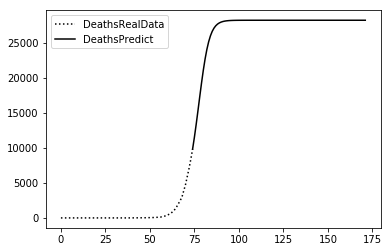

In [12]:
#visualization
plt.plot(final_df_Deaths.iloc[:len(data_Deaths)+1,],color="black",linestyle=":",label='DeathsRealData')
plt.plot(final_df_Deaths.iloc[len(data_Deaths)::,],color="black",label='DeathsPredict')
plt.legend()

In [13]:
#Third, we predict recovered cases in USA.
df_Recovered=DataProcess(path,country).ExtractRecoveredCases()
scaler = MinMaxScaler(feature_range=(0, 1))
data_Recovered = scaler.fit_transform(df_Recovered)
look_back = 1 
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
trainX, trainY = create_dataset(data_Recovered, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))


In [14]:
model.fit(trainX, trainY, epochs=10, batch_size=1)

Epoch 1/10
72/72 [==============================] - 2s 24ms/step - loss: 0.0012
Epoch 2/10
72/72 [==============================] - 2s 24ms/step - loss: 0.0019
Epoch 3/10
72/72 [==============================] - 2s 28ms/step - loss: 0.0017
Epoch 4/10
72/72 [==============================] - 2s 28ms/step - loss: 0.0012
Epoch 5/10
72/72 [==============================] - 2s 29ms/step - loss: 0.0016
Epoch 6/10
72/72 [==============================] - 2s 27ms/step - loss: 0.0015
Epoch 7/10
72/72 [==============================] - 2s 27ms/step - loss: 0.0013
Epoch 8/10
72/72 [==============================] - 2s 27ms/step - loss: 0.0011
Epoch 9/10
72/72 [==============================] - 2s 25ms/step - loss: 5.1472e-04
Epoch 10/10
72/72 [==============================] - 2s 25ms/step - loss: 0.0014


In [15]:
PredictRecovered = []
TimePredict = 100
for i in range(TimePredict):
    predict_step=model.predict(trainX)[-1]
    PredictRecovered.append(predict_step)
    trainX = np.append(trainX[1:,:,:],[[predict_step]],axis=0)
predict_not_scale=scaler.inverse_transform(PredictRecovered)
final_df_Recovered=pd.DataFrame(np.append(df_Recovered,predict_not_scale[2::,]))

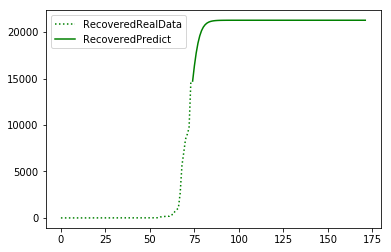

In [16]:
plt.plot(final_df_Recovered.iloc[:len(data_Recovered)+1,],color="green",linestyle=":",label='RecoveredRealData')
plt.plot(final_df_Recovered.iloc[len(data_Recovered)::,],color="green",label='RecoveredPredict')
plt.legend()

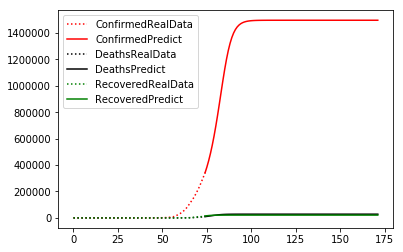

In [17]:
#summary plot 
plt.plot(final_df_Confirmed.iloc[:len(data_Confirmed)+1,],color="red",linestyle=":",label='ConfirmedRealData')
plt.plot(final_df_Confirmed.iloc[len(data_Confirmed)::,],color="red",label='ConfirmedPredict')
plt.plot(final_df_Deaths.iloc[:len(data_Deaths)+1,],color="black",linestyle=":",label='DeathsRealData')
plt.plot(final_df_Deaths.iloc[len(data_Deaths)::,],color="black",label='DeathsPredict')
plt.plot(final_df_Recovered.iloc[:len(data_Recovered)+1,],color="green",linestyle=":",label='RecoveredRealData')
plt.plot(final_df_Recovered.iloc[len(data_Recovered)::,],color="green",label='RecoveredPredict')
plt.legend()